<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/pepijn/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [9]:
traintransform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(128),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = traintransform

batch_size = 32
num_workers = 2

trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([8, 1, 6, 3, 8, 1, 8, 8, 3, 4, 7, 0, 1, 8, 0, 9, 9, 1, 6, 7, 3, 8, 7, 5,
        3, 8, 1, 0, 8, 0, 8, 3])


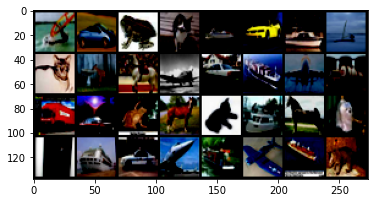

In [4]:
def showimage(image):
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)

images, labels = next(iter(trainloader))
showimage(torchvision.utils.make_grid(images))
print(labels)

In [22]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MyModel()
model

MyModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
)

In [33]:
def train(model, optimizer, trainloader, testloader, criterion=nn.CrossEntropyLoss(), epochs=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(device)

    lowest_testloss = np.Inf

    for epoch in range(epochs):

        # training
        trainloss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(images)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()
        print(f"Epoch {epoch}, Training loss: {trainloss}")

        # validation
        testloss = 0
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                out = model(images)
                loss = criterion(out, labels)
                testloss += loss
        print(f"Epoch {epoch}, Validation loss: {testloss}")

        if testloss > lowest_testloss: 
            break
        lowest_testloss = testloss
    
    # final accuracy
    totacc = 0
    n = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            out = model(images)
            topv, topi = torch.topk(out, 1, dim=1)
            labels.resize_(*topi.shape)
            eq = topi == labels
            acc = torch.mean(eq.type(torch.FloatTensor))
            totacc += acc.item()
            n += 1
    totacc /= n
    print(f"The final total accuracy is: {totacc * 100}")

In [32]:
train(model, 
      optim.SGD(params=model.parameters(), lr=0.005),
      trainloader, 
      testloader, epochs=0)

cuda
The final total accuracy is: 99.98600447856685


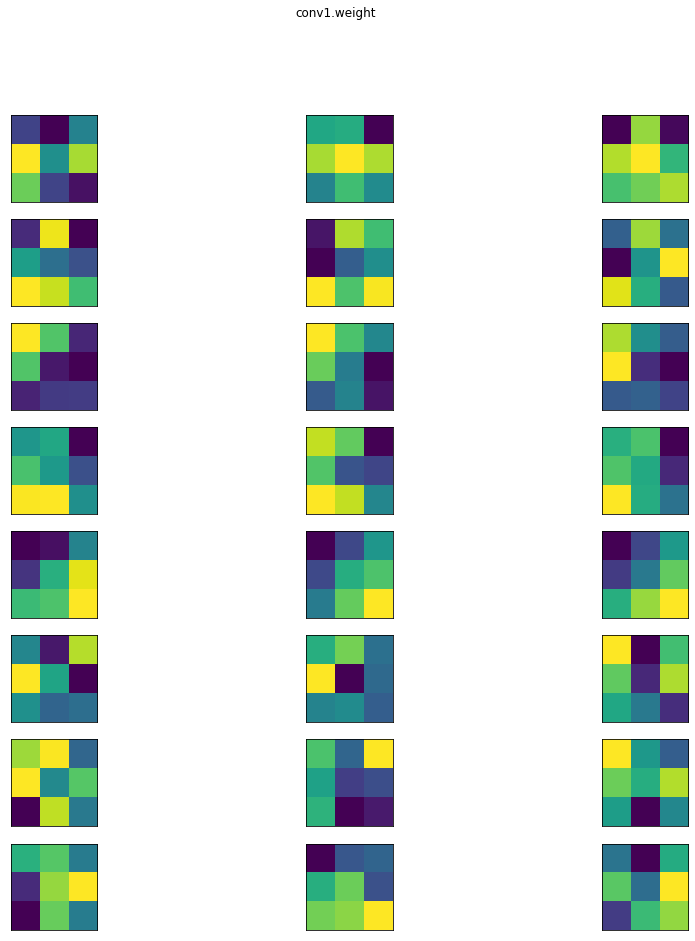

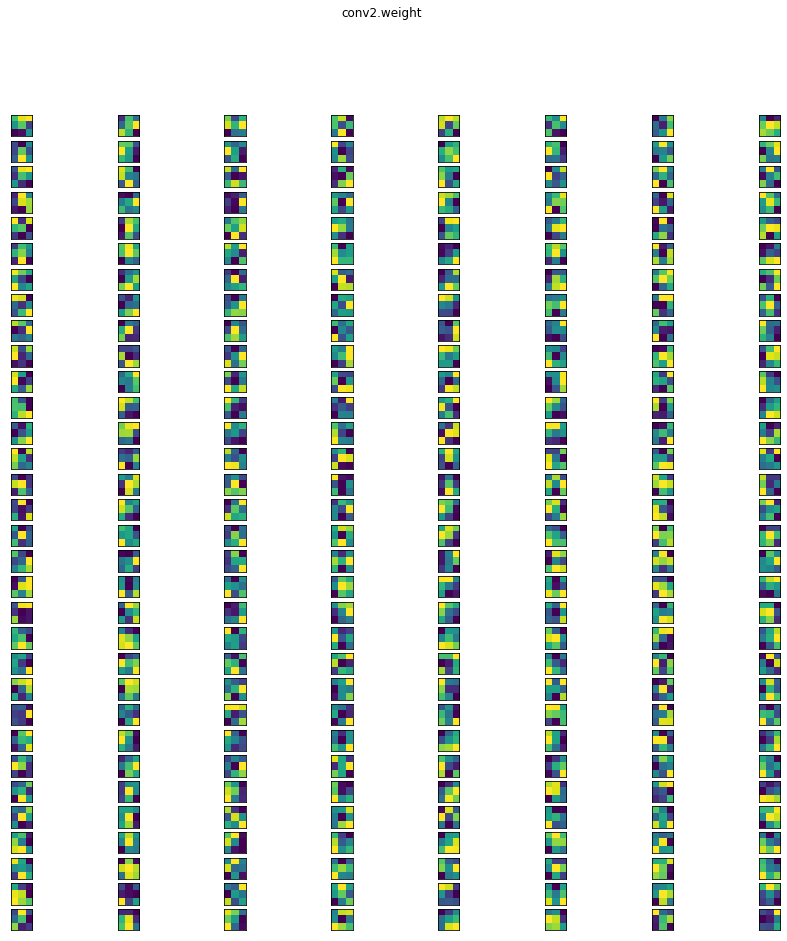

In [83]:
def show_filters(model, depth=2, tag="conv"):
    count = 0
    for key, filters in model.state_dict().items():
        if tag not in key or "weight" not in key:
            continue
            
        if count >= depth:
            break
        count += 1
        
        fig, axs = plt.subplots(filters.shape[0], filters.shape[1], figsize=(15,15))
        fig.suptitle(key)

        max, min = filters.max(), filters.min()
        f = (filters - min) / (max - min)
        f = f.cpu().numpy()

        for i in range(f.shape[0]):
            for j in range(f.shape[1]):
                ax = axs[i,j]
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(f[i,j,:,:])
        plt.plot()

        
show_filters(model)